<a href="https://colab.research.google.com/github/jasimrashid/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

# updates column name to lower case
df.columns = [i.lower() for i in df.columns]

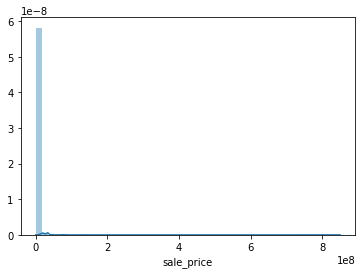

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df['sale_price'])  
plt.show()
# df['sale_price'].plot()

In [0]:
#TODO: remove outliers?


In [7]:
df.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'ease-ment',
       'building_class_at_present', 'address', 'apartment_number', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')

**1.** Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [0]:
df_subset = df[(df['building_class_category'] == '01 ONE FAMILY DWELLINGS') & (df['sale_price'] < 2000000) & (df['sale_price'] > 100000)]

In [23]:
subset

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,04/30/2019
23031,4,OTHER,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,04/30/2019
23032,4,OTHER,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,04/30/2019
23033,4,OTHER,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,04/30/2019


**2.** Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [38]:
df_subset['sale_date'] = pd.to_datetime(df_subset['sale_date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2019-04-01')
train = df_subset[df_subset['sale_date'] < cutoff]
test = df_subset[df_subset['sale_date'] >= cutoff]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
train.shape, test.shape, df_subset.shape

((2507, 21), (644, 21), (3151, 21))

**3.** Do one-hot encoding of categorical features.

In [42]:
train.describe(exclude='number')

,borough,neighborhood,building_class_category,tax_class_at_present,building_class_at_present,address,apartment_number,land_square_feet,building_class_at_time_of_sale,sale_date
count,2507,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,5,6,1,2,13,2497,1,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,118-20 202ND STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1204,2382,2507,2476,919,2,1,234,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


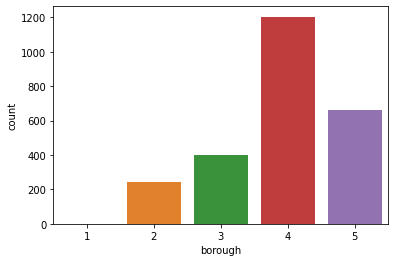

In [44]:
sns.countplot(train['borough'])

In [49]:
target = 'sale_price'
high_cardinality = ['address','land_square_feet','sale_date']
features = train.columns.drop([target] + high_cardinality)
features
# potetntially building_class_at_present 13 and building_class_at_time_of_sale 11

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'ease-ment',
       'building_class_at_present', 'apartment_number', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'gross_square_feet', 'year_built', 'tax_class_at_time_of_sale',
       'building_class_at_time_of_sale'],
      dtype='object')

In [0]:
X_train = train[features]
y_train == train[target]

X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [51]:
X_train

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,apartment_number,zip_code,residential_units,commercial_units,total_units,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,5,OTHER,01 ONE FAMILY DWELLINGS,1,4081,44,NaN,A2,NaN,10306.0,1.0,0.0,1.0,921.0,1950.0,1,A2
18130,5,OTHER,01 ONE FAMILY DWELLINGS,1,2373,201,NaN,A5,NaN,10314.0,1.0,0.0,1.0,2128.0,1980.0,1,A5
18132,5,OTHER,01 ONE FAMILY DWELLINGS,1,1132,42,NaN,A1,NaN,10302.0,1.0,0.0,1.0,1807.0,2018.0,1,A1
18134,5,OTHER,01 ONE FAMILY DWELLINGS,1,3395,37,NaN,A2,NaN,10305.0,1.0,0.0,1.0,621.0,1930.0,1,A2


In [53]:
X_test

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,apartment_number,zip_code,residential_units,commercial_units,total_units,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,NaN,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,A1
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,NaN,A2,NaN,10465.0,1.0,0.0,1.0,720.0,1935.0,1,A2
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,NaN,A1,NaN,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,A1
18280,3,OTHER,01 ONE FAMILY DWELLINGS,1,7813,24,NaN,A5,NaN,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,A5
18285,3,OTHER,01 ONE FAMILY DWELLINGS,1,8831,160,NaN,A9,NaN,11229.0,1.0,0.0,1.0,840.0,1925.0,1,A9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,NaN,11422.0,1.0,0.0,1.0,1478.0,1925.0,1,A2
23031,4,OTHER,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,NaN,11420.0,1.0,0.0,1.0,1280.0,1930.0,1,A1
23032,4,OTHER,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,NaN,11420.0,1.0,0.0,1.0,1333.0,1945.0,1,A0
23033,4,OTHER,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,NaN,11434.0,1.0,0.0,1.0,1020.0,1935.0,1,A1


In [55]:
X_train

,borough_3,borough_4,borough_2,borough_5,borough_1,neighborhood_OTHER,neighborhood_FLUSHING-NORTH,neighborhood_BEDFORD STUYVESANT,neighborhood_FOREST HILLS,neighborhood_BOROUGH PARK,neighborhood_ASTORIA,building_class_category_01 ONE FAMILY DWELLINGS,tax_class_at_present_1,tax_class_at_present_1D,block,lot,ease-ment,building_class_at_present_A9,building_class_at_present_A1,building_class_at_present_A5,building_class_at_present_A0,building_class_at_present_A2,building_class_at_present_A3,building_class_at_present_S1,building_class_at_present_A4,building_class_at_present_A6,building_class_at_present_A8,building_class_at_present_B2,building_class_at_present_S0,building_class_at_present_B3,apartment_number_nan,apartment_number_RP.,zip_code,residential_units,commercial_units,total_units,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale_A9,building_class_at_time_of_sale_A1,building_class_at_time_of_sale_A5,building_class_at_time_of_sale_A0,building_class_at_time_of_sale_A2,building_class_at_time_of_sale_A3,building_class_at_time_of_sale_S1,building_class_at_time_of_sale_A4,building_class_at_time_of_sale_A6,building_class_at_time_of_sale_A8,building_class_at_time_of_sale_S0
44,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5495,801,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,1,1,0,7918,72,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,1,1,0,4210,19,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5212,69,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7930,121,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,1,1,0,4081,44,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10306.0,1.0,0.0,1.0,921.0,1950.0,1,0,0,0,0,1,0,0,0,0,0,0
18130,0,0,0,1,0,1,0,0,0,0,0,1,1,0,2373,201,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,10314.0,1.0,0.0,1.0,2128.0,1980.0,1,0,0,1,0,0,0,0,0,0,0,0
18132,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1132,42,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10302.0,1.0,0.0,1.0,1807.0,2018.0,1,0,1,0,0,0,0,0,0,0,0,0
18134,0,0,0,1,0,1,0,0,0,0,0,1,1,0,3395,37,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10305.0,1.0,0.0,1.0,621.0,1930.0,1,0,0,0,0,1,0,0,0,0,0,0


In [56]:
X_test

,borough_3,borough_4,borough_2,borough_5,borough_1,neighborhood_OTHER,neighborhood_FLUSHING-NORTH,neighborhood_BEDFORD STUYVESANT,neighborhood_FOREST HILLS,neighborhood_BOROUGH PARK,neighborhood_ASTORIA,building_class_category_01 ONE FAMILY DWELLINGS,tax_class_at_present_1,tax_class_at_present_1D,block,lot,ease-ment,building_class_at_present_A9,building_class_at_present_A1,building_class_at_present_A5,building_class_at_present_A0,building_class_at_present_A2,building_class_at_present_A3,building_class_at_present_S1,building_class_at_present_A4,building_class_at_present_A6,building_class_at_present_A8,building_class_at_present_B2,building_class_at_present_S0,building_class_at_present_B3,apartment_number_nan,apartment_number_RP.,zip_code,residential_units,commercial_units,total_units,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale_A9,building_class_at_time_of_sale_A1,building_class_at_time_of_sale_A5,building_class_at_time_of_sale_A0,building_class_at_time_of_sale_A2,building_class_at_time_of_sale_A3,building_class_at_time_of_sale_S1,building_class_at_time_of_sale_A4,building_class_at_time_of_sale_A6,building_class_at_time_of_sale_A8,building_class_at_time_of_sale_S0
18235,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5913,878,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5488,48,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10465.0,1.0,0.0,1.0,720.0,1935.0,1,0,0,0,0,1,0,0,0,0,0,0
18244,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5936,31,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7813,24,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,0,0,1,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,0,0,0,0,0,1,1,0,8831,160,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,0,1,0,0,0,1,0,0,0,0,0,1,1,0,13215,3,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,11422.0,1.0,0.0,1.0,1478.0,1925.0,1,0,0,0,0,1,0,0,0,0,0,0
23031,0,1,0,0,0,1,0,0,0,0,0,1,1,0,11612,73,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11420.0,1.0,0.0,1.0,1280.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
23032,0,1,0,0,0,1,0,0,0,0,0,1,1,0,11808,50,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,11420.0,1.0,0.0,1.0,1333.0,1945.0,1,0,0,0,1,0,0,0,0,0,0,0
23033,0,1,0,0,0,1,0,0,0,0,0,1,1,0,12295,23,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11434.0,1.0,0.0,1.0,1020.0,1935.0,1,0,1,0,0,0,0,0,0,0,0,0


In [0]:
# dropping a column which has all NaNs
X_test_1 = X_test.drop(['ease-ment'], axis=1)

In [0]:
# dropping a column which has all NaNs
X_train_1 = X_train.drop(['ease-ment'], axis=1)

**4.** Do feature selection with SelectKBest.

In [151]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=49)

X_train_selected = selector.fit_transform(X_train_1, y_train)
X_test_selected = selector.transform(X_test_1)

# got rid of ease-ment column

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 11 27 28 29 30 37 48] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [111]:
X_train_selected.shape

(2507, 10)

In [112]:
X_test_selected.shape

(644, 10)

In [152]:
selected_mask = selector.get_support()
all_names = X_train_1.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print ('Features selected:')
for name in selected_names:
  print (name)

print()
print ('Features excluded:')
for name in unselected_names:
  print (name)


Features selected:
borough_3
borough_4
borough_2
borough_5
borough_1
neighborhood_OTHER
neighborhood_FLUSHING-NORTH
neighborhood_BEDFORD STUYVESANT
neighborhood_FOREST HILLS
neighborhood_BOROUGH PARK
neighborhood_ASTORIA
building_class_category_01 ONE FAMILY DWELLINGS
tax_class_at_present_1
tax_class_at_present_1D
block
lot
building_class_at_present_A9
building_class_at_present_A1
building_class_at_present_A5
building_class_at_present_A0
building_class_at_present_A2
building_class_at_present_A3
building_class_at_present_S1
building_class_at_present_A4
building_class_at_present_A6
building_class_at_present_A8
building_class_at_present_B2
building_class_at_present_S0
building_class_at_present_B3
apartment_number_nan
apartment_number_RP.
zip_code
residential_units
commercial_units
total_units
gross_square_feet
year_built
tax_class_at_time_of_sale
building_class_at_time_of_sale_A9
building_class_at_time_of_sale_A1
building_class_at_time_of_sale_A5
building_class_at_time_of_sale_A0
building

**5.** Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

Scenario 1: on all features

In [107]:
# Ridge using Normalize=True Parameter 
from sklearn.linear_model import Ridge, RidgeCV

alphas = [0.002, 0.005, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(X_train_1, y_train)
y_pred = ridge.predict(X_train_1)
ridge.alpha_

0.002

In [108]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_pred, y_train)
print(f'Train Mean Absolute Error: ${mae:,.0f}')


Train Mean Absolute Error: $154,500


Scenario 2: on kbest k features


In [0]:
# Ridge using Normalize=True Parameter 
from sklearn.linear_model import Ridge, RidgeCV

alphas = [0.002, 0.005, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(X_train_selected, y_train)
y_pred = ridge.predict(X_train_selected)

In [154]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_pred, y_train)
print(f'Train Mean Absolute Error: ${mae:,.0f}')


Train Mean Absolute Error: $154,500


MAE (train)
- k=5 -> 214K
- k=10 -> 206K
- k=15 -> 185K
- k=20 -> 178K
- k=30 -> 173K
- k=50 -> 154K

**6.** Get mean absolute error for the test set.

In [109]:
# scenario 1: all features
y_pred = ridge.predict(X_test_1)
mae = mean_absolute_error(y_pred, y_test)
print(f'Test Mean Absolute Error: ${mae:,.0f}')

Test Mean Absolute Error: $159,443


In [155]:
# scenario 2: used Kbest = k
y_pred = ridge.predict(X_test_selected)
mae = mean_absolute_error(y_pred, y_test)
print(f'Test Mean Absolute Error: ${mae:,.0f}')

Test Mean Absolute Error: $159,443


MAE (train)
- k=5 -> 212K
- k=10 -> 207K
- k=15 -> 177K
- k=20 -> 172K
- k=30 -> 173K
- k=50 -> 159K

**Linear regression instead of Ridge**

In [110]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_1, y_train)
y_pred = model.predict(X_train_1)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_pred, y_train)
print(f'Train Mean Absolute Error: ${mae:,.0f}')

y_pred = ridge.predict(X_test_1)
mae = mean_absolute_error(y_pred, y_test)
print(f'Test Mean Absolute Error: ${mae:,.0f}')


Train Mean Absolute Error: $154,456
Test Mean Absolute Error: $159,443
